In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel(r"C:\Users\hamsa\OneDrive\Desktop\my proj\NIOT internship\Data\TS_Ssp.xlsx",
                   sheet_name='Actuals', 
                   usecols='A,E:M,Q:Y')
df = pd.concat([df.iloc[0:0], df.iloc[8785:]], ignore_index=True)
df.head()


,Time[UTC],Temp_010.0m,Temp_015.0m,Temp_020.0m,Temp_030.0m,Temp_050.0m,Temp_075.0m,Temp_100.0m,Temp_200.0m,Temp_500.0m,Salt_010.0m,Salt_015.0m,Salt_020.0m,Salt_030.0m,Salt_050.0m,Salt_075.0m,Salt_100.0m,Salt_200.0m,Salt_500.0m
0,2013-01-01 01:00:00,26.291,26.292,26.294,26.298,26.299,23.501,22.441,16.722,12.551,36.773,36.777,36.767,36.771,36.759,36.259,36.298,35.856,35.710
1,2013-01-01 02:00:00,26.293,26.297,26.296,26.294,26.298,23.547,22.626,16.762,12.627,36.773,36.777,36.766,36.770,36.764,36.270,36.312,35.746,35.719
2,2013-01-01 03:00:00,26.282,26.285,26.290,26.292,26.297,23.821,22.638,16.738,12.579,36.773,36.767,36.766,36.770,36.762,36.298,36.317,35.801,35.714
3,2013-01-01 04:00:00,26.281,26.286,26.285,26.280,26.290,24.843,22.672,16.744,12.583,36.772,36.777,36.766,36.771,36.759,36.509,36.319,35.770,35.714
4,2013-01-01 05:00:00,26.278,26.283,26.285,26.284,26.288,24.421,22.686,16.757,12.582,36.774,36.778,36.768,36.772,36.761,36.448,36.323,35.788,35.714


In [3]:
print(df.shape)

(70127, 19)


In [5]:
print(df.isnull().sum())

Time[UTC]          0
Temp_010.0m     9005
Temp_015.0m     9646
Temp_020.0m     9485
Temp_030.0m     9025
Temp_050.0m    12509
Temp_075.0m     9039
Temp_100.0m     8988
Temp_200.0m    14343
Temp_500.0m     8975
Salt_010.0m    20343
Salt_015.0m    19555
Salt_020.0m    10367
Salt_030.0m    20376
Salt_050.0m    31516
Salt_075.0m     9039
Salt_100.0m    12166
Salt_200.0m    14343
Salt_500.0m     9082
dtype: int64


In [7]:
print(f"Total rows: {len(df)}")
print(f"Missing value percentages:")
print((df.isnull().sum() / len(df) * 100).round(2))

Total rows: 70127
Missing value percentages:
Time[UTC]       0.00
Temp_010.0m    12.84
Temp_015.0m    13.76
Temp_020.0m    13.53
Temp_030.0m    12.87
Temp_050.0m    17.84
Temp_075.0m    12.89
Temp_100.0m    12.82
Temp_200.0m    20.45
Temp_500.0m    12.80
Salt_010.0m    29.01
Salt_015.0m    27.89
Salt_020.0m    14.78
Salt_030.0m    29.06
Salt_050.0m    44.94
Salt_075.0m    12.89
Salt_100.0m    17.35
Salt_200.0m    20.45
Salt_500.0m    12.95
dtype: float64


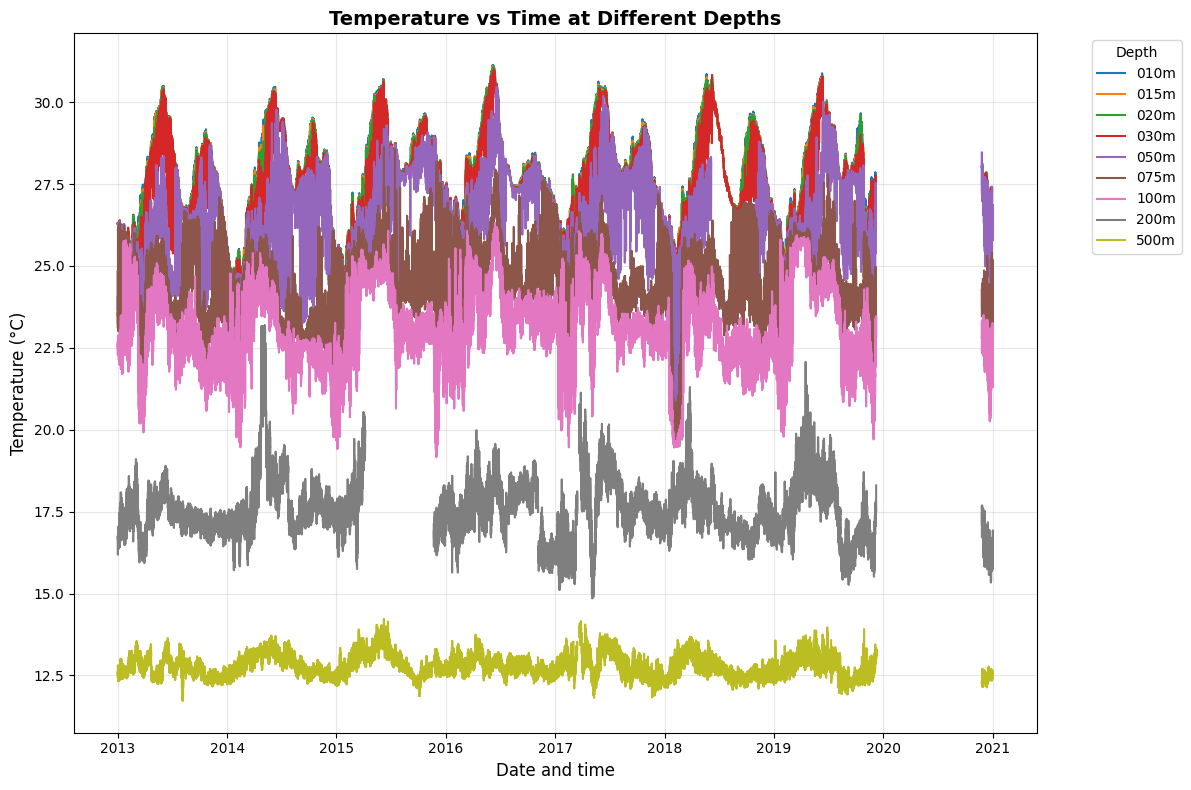

In [9]:
df['Time[UTC]'] = pd.to_datetime(df['Time[UTC]'])

temp_columns = [col for col in df.columns if col.startswith('Temp_')]

plt.figure(figsize=(12, 8))

for col in temp_columns:
    depth_label = col.replace('Temp_', '').replace('.0m', 'm')
    
    plt.plot(df['Time[UTC]'], df[col], label=depth_label, linewidth=1.5)

plt.xlabel('Date and time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Temperature vs Time at Different Depths', fontsize=14, fontweight='bold')
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_idx, sequence_length):
        self.data = data
        self.target_idx = target_idx
        self.sequence_length = sequence_length
        self.X, self.y = self.create_sequences()

    def create_sequences(self):
        X, y = [], []
        step_size = max(1, self.sequence_length // 4)
        
        for i in range(self.sequence_length, len(self.data), step_size):
            X.append(self.data[i-self.sequence_length:i])
            y.append(self.data[i, self.target_idx])
            
        return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class FastLSTM(nn.Module):
    def __init__(self, input_size, lstm_units=64, sequence_length=24):
        super(FastLSTM, self).__init__()
        self.lstm_units = lstm_units
        
        self.lstm1 = nn.LSTM(input_size, lstm_units, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True, dropout=0.2)
        
        self.fc1 = nn.Linear(lstm_units//2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out.squeeze()

def create_basic_features(df, target_column):
    df_enhanced = df.copy()
    
    feature_cols = [col for col in df.columns if col not in ['Time[UTC]', target_column]]
    
    for col in feature_cols:
        df_enhanced[f'{col}_rolling_mean_6'] = df[col].rolling(window=6, min_periods=1).mean()
        df_enhanced[f'{col}_lag_1'] = df[col].shift(1)
        df_enhanced[f'{col}_lag_3'] = df[col].shift(3)
    
    return df_enhanced

class FastLSTMImputer:
    def __init__(self, sequence_length=24, lstm_units=64):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.scaler = StandardScaler()
        self.model = None
        self.device = device
        
    def prepare_data_fast(self, df, target_column):
        df_enhanced = create_basic_features(df, target_column)
        
        feature_cols = [col for col in df_enhanced.columns if col != 'Time[UTC]']
        
        df_filled = df_enhanced[feature_cols].copy()
        df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')
        df_filled = df_filled.interpolate(method='linear')
        df_filled = df_filled.fillna(df_filled.mean())
        
        scaled_data = self.scaler.fit_transform(df_filled)
        target_idx = list(df_filled.columns).index(target_column)
        
        return scaled_data, target_idx, list(df_filled.columns)
    
    def train_fast(self, df, target_column, epochs=30, batch_size=128):
        print(f"Training fast LSTM model for {target_column}...")
        
        scaled_data, target_idx, feature_cols = self.prepare_data_fast(df, target_column)
        
        print(f"Features created: {len(feature_cols)} features")
        
        dataset = TimeSeriesDataset(scaled_data, target_idx, self.sequence_length)
        
        if len(dataset) == 0:
            print("ERROR: No training sequences created!")
            return None
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"Training sequences: {len(dataset)}, Features: {len(feature_cols)}")
        
        self.model = FastLSTM(len(feature_cols), self.lstm_units, self.sequence_length)
        self.model.to(self.device)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                    val_outputs = self.model(X_val)
                    val_loss += criterion(val_outputs, y_val).item()
            
            avg_val_loss = val_loss / len(val_loader)
            scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), f'fast_model_{target_column}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    self.model.load_state_dict(torch.load(f'fast_model_{target_column}.pth'))
                    break
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}')
        
        print(f"Fast training completed. Best val loss: {best_val_loss:.4f}")
        return True
    
    def predict_gaps_fast(self, df, target_column):
        print(f"Fast gap filling for {target_column}...")
        
        if self.model is None:
            print("ERROR: Model not trained!")
            return df
        
        df_filled = df.copy()
        
        df_enhanced = create_basic_features(df, target_column)
        feature_cols = [col for col in df_enhanced.columns if col != 'Time[UTC]']
        
        missing_mask = df[target_column].isnull()
        missing_indices = df[missing_mask].index.tolist()
        
        print(f"Found {len(missing_indices)} missing values to fill")
        
        if len(missing_indices) == 0:
            return df_filled
        
        df_enhanced_filled = df_enhanced[feature_cols].copy()
        df_enhanced_filled = df_enhanced_filled.fillna(method='ffill').fillna(method='bfill')
        df_enhanced_filled = df_enhanced_filled.interpolate(method='linear')
        df_enhanced_filled = df_enhanced_filled.fillna(df_enhanced_filled.mean())
        
        filled_count = 0
        self.model.eval()
        
        with torch.no_grad():
            for idx in missing_indices:
                if idx >= self.sequence_length:
                    start_idx = idx - self.sequence_length
                    sequence_data = df_enhanced_filled.iloc[start_idx:idx].copy()
                    
                    try:
                        sequence_scaled = self.scaler.transform(sequence_data)
                        sequence_tensor = torch.tensor(sequence_scaled, dtype=torch.float32).unsqueeze(0).to(self.device)
                        
                        prediction_scaled = self.model(sequence_tensor).cpu().item()
                        
                        dummy_array = np.zeros((1, len(feature_cols)))
                        target_idx = feature_cols.index(target_column)
                        dummy_array[0, target_idx] = prediction_scaled
                        
                        prediction_actual = self.scaler.inverse_transform(dummy_array)[0, target_idx]
                        
                        if target_column.startswith('Temp_'):
                            prediction_actual = np.clip(prediction_actual, -2, 35)
                        elif target_column.startswith('Salt_'):
                            prediction_actual = np.clip(prediction_actual, 30, 42)
                        
                        df_filled.loc[idx, target_column] = prediction_actual
                        df_enhanced_filled.loc[idx, target_column] = prediction_actual
                        filled_count += 1
                        
                    except Exception as e:
                        continue
        
        print(f"Fast filling: {filled_count}/{len(missing_indices)} values filled")
        return df_filled

def fast_gap_filling(df):
    print("FAST LSTM GAP FILLING STARTED")
    print("="*50)
    
    missing_counts = df.isnull().sum()
    columns_with_missing = missing_counts[missing_counts > 0]
    columns_with_missing = columns_with_missing[columns_with_missing.index != 'Time[UTC]']
    columns_to_fill = columns_with_missing.sort_values().index.tolist()
    
    print("Columns to process:")
    for col in columns_to_fill:
        print(f"  {col}: {missing_counts[col]} missing values")
    print("\n" + "="*50)
    
    df_result = df.copy()
    
    for column in columns_to_fill:
        print(f"\nProcessing: {column}")
        print("-" * 30)
        
        imputer = FastLSTMImputer(sequence_length=12, lstm_units=64)
        
        success = imputer.train_fast(df_result, column, epochs=30)
        
        if success:
            df_result = imputer.predict_gaps_fast(df_result, column)
            
            remaining = df_result[column].isnull().sum()
            filled = missing_counts[column] - remaining
            fill_rate = (filled / missing_counts[column]) * 100
            
            print(f"Results: {filled}/{missing_counts[column]} filled ({fill_rate:.1f}%)")
        else:
            print(f"Failed to process {column}")
        
        print("-" * 30)
    
    return df_result

if __name__ == "__main__":
    print("INITIAL MISSING VALUES:")
    print(df.isnull().sum())
    print("\n" + "="*50)
    
    df_fast_filled = fast_gap_filling(df)
    
    print("\n" + "="*50)
    print("FINAL RESULTS:")
    print("="*50)
    print("Remaining missing values:")
    print(df_fast_filled.isnull().sum())
    
    print("\nACCURACY ANALYSIS:")
    print("-" * 30)
    
    total_accuracy = 0
    count = 0
    total_filled = 0
    total_missing = 0
    
    for column in df.columns:
        if column != 'Time[UTC]' and df[column].isnull().sum() > 0:
            original_missing = df[column].isnull().sum()
            remaining_missing = df_fast_filled[column].isnull().sum()
            filled_count = original_missing - remaining_missing
            
            total_filled += filled_count
            total_missing += original_missing
            
            if filled_count > 0:
                orig_mean = df[column].mean()
                filled_values = df_fast_filled[df[column].isnull()][column]
                
                if len(filled_values) > 0 and not filled_values.isnull().all():
                    filled_mean = filled_values.mean()
                    if not np.isnan(filled_mean) and not np.isnan(orig_mean) and orig_mean != 0:
                        diff = abs(orig_mean - filled_mean) / orig_mean * 100
                        accuracy = 100 - diff
                        total_accuracy += accuracy
                        count += 1
                        print(f"{column}: {accuracy:.1f}% accuracy, {filled_count}/{original_missing} filled")
                    else:
                        print(f"{column}: {filled_count}/{original_missing} filled")
                else:
                    print(f"{column}: No valid fills")
            else:
                print(f"{column}: 0/{original_missing} filled")
    
    overall_accuracy = total_accuracy / count if count > 0 else 0
    overall_fill_rate = (total_filled / total_missing) * 100 if total_missing > 0 else 0
    
    print("\n" + "="*50)
    print("FINAL SUMMARY:")
    print(f"Overall Fill Rate: {overall_fill_rate:.1f}% ({total_filled}/{total_missing})")
    print(f"Overall Accuracy: {overall_accuracy:.1f}%")
    print("="*50)
    

Using device: cuda
INITIAL MISSING VALUES:
Time[UTC]          0
Temp_010.0m     9005
Temp_015.0m     9646
Temp_020.0m     9485
Temp_030.0m     9025
Temp_050.0m    12509
Temp_075.0m     9039
Temp_100.0m     8988
Temp_200.0m    14343
Temp_500.0m     8975
Salt_010.0m    20343
Salt_015.0m    19555
Salt_020.0m    10367
Salt_030.0m    20376
Salt_050.0m    31516
Salt_075.0m     9039
Salt_100.0m    12166
Salt_200.0m    14343
Salt_500.0m     9082
dtype: int64

FAST LSTM GAP FILLING STARTED
Columns to process:
  Temp_500.0m: 8975 missing values
  Temp_100.0m: 8988 missing values
  Temp_010.0m: 9005 missing values
  Temp_030.0m: 9025 missing values
  Salt_075.0m: 9039 missing values
  Temp_075.0m: 9039 missing values
  Salt_500.0m: 9082 missing values
  Temp_020.0m: 9485 missing values
  Temp_015.0m: 9646 missing values
  Salt_020.0m: 10367 missing values
  Salt_100.0m: 12166 missing values
  Temp_050.0m: 12509 missing values
  Salt_200.0m: 14343 missing values
  Temp_200.0m: 14343 missing values

In [19]:
df_fast_filled.to_csv('fast_lstm_oceanographic_filled.csv', index=False)
print("saved!")



Fast LSTM gap filling completed and saved!


In [ ]:
df['Time[UTC]'] = pd.to_datetime(df['Time[UTC]'])

temp_columns = [col for col in df.columns if col.startswith('Temp_')]

plt.figure(figsize=(12, 8))

for col in temp_columns:
    depth_label = col.replace('Temp_', '').replace('.0m', 'm')
    
    plt.plot(df['Time[UTC]'], df[col], label=depth_label, linewidth=1.5)

plt.xlabel('Date and time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Temperature vs Time at Different Depths', fontsize=14, fontweight='bold')
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df_moderate_filled.to_csv('moderate_lstm_oceanographic_filled.csv', index=False)
print("\nModerate LSTM gap filling completed and saved!")

Using device: cuda
INITIAL MISSING VALUES:
Time[UTC]          0
Temp_010.0m     9005
Temp_015.0m     9646
Temp_020.0m     9485
Temp_030.0m     9025
Temp_050.0m    12509
Temp_075.0m     9039
Temp_100.0m     8988
Temp_200.0m    14343
Temp_500.0m     8975
Salt_010.0m    20343
Salt_015.0m    19555
Salt_020.0m    10367
Salt_030.0m    20376
Salt_050.0m    31516
Salt_075.0m     9039
Salt_100.0m    12166
Salt_200.0m    14343
Salt_500.0m     9082
dtype: int64

ENHANCED LSTM GAP FILLING STARTED
Using: 3-Layer Bidirectional LSTM + Sequence Length 24 + Enhanced Features
Columns to process:
  Temp_500.0m: 8975 missing values
  Temp_100.0m: 8988 missing values
  Temp_010.0m: 9005 missing values
  Temp_030.0m: 9025 missing values
  Salt_075.0m: 9039 missing values
  Temp_075.0m: 9039 missing values
  Salt_500.0m: 9082 missing values
  Temp_020.0m: 9485 missing values
  Temp_015.0m: 9646 missing values
  Salt_020.0m: 10367 missing values
  Salt_100.0m: 12166 missing values
  Temp_050.0m: 12509 missing

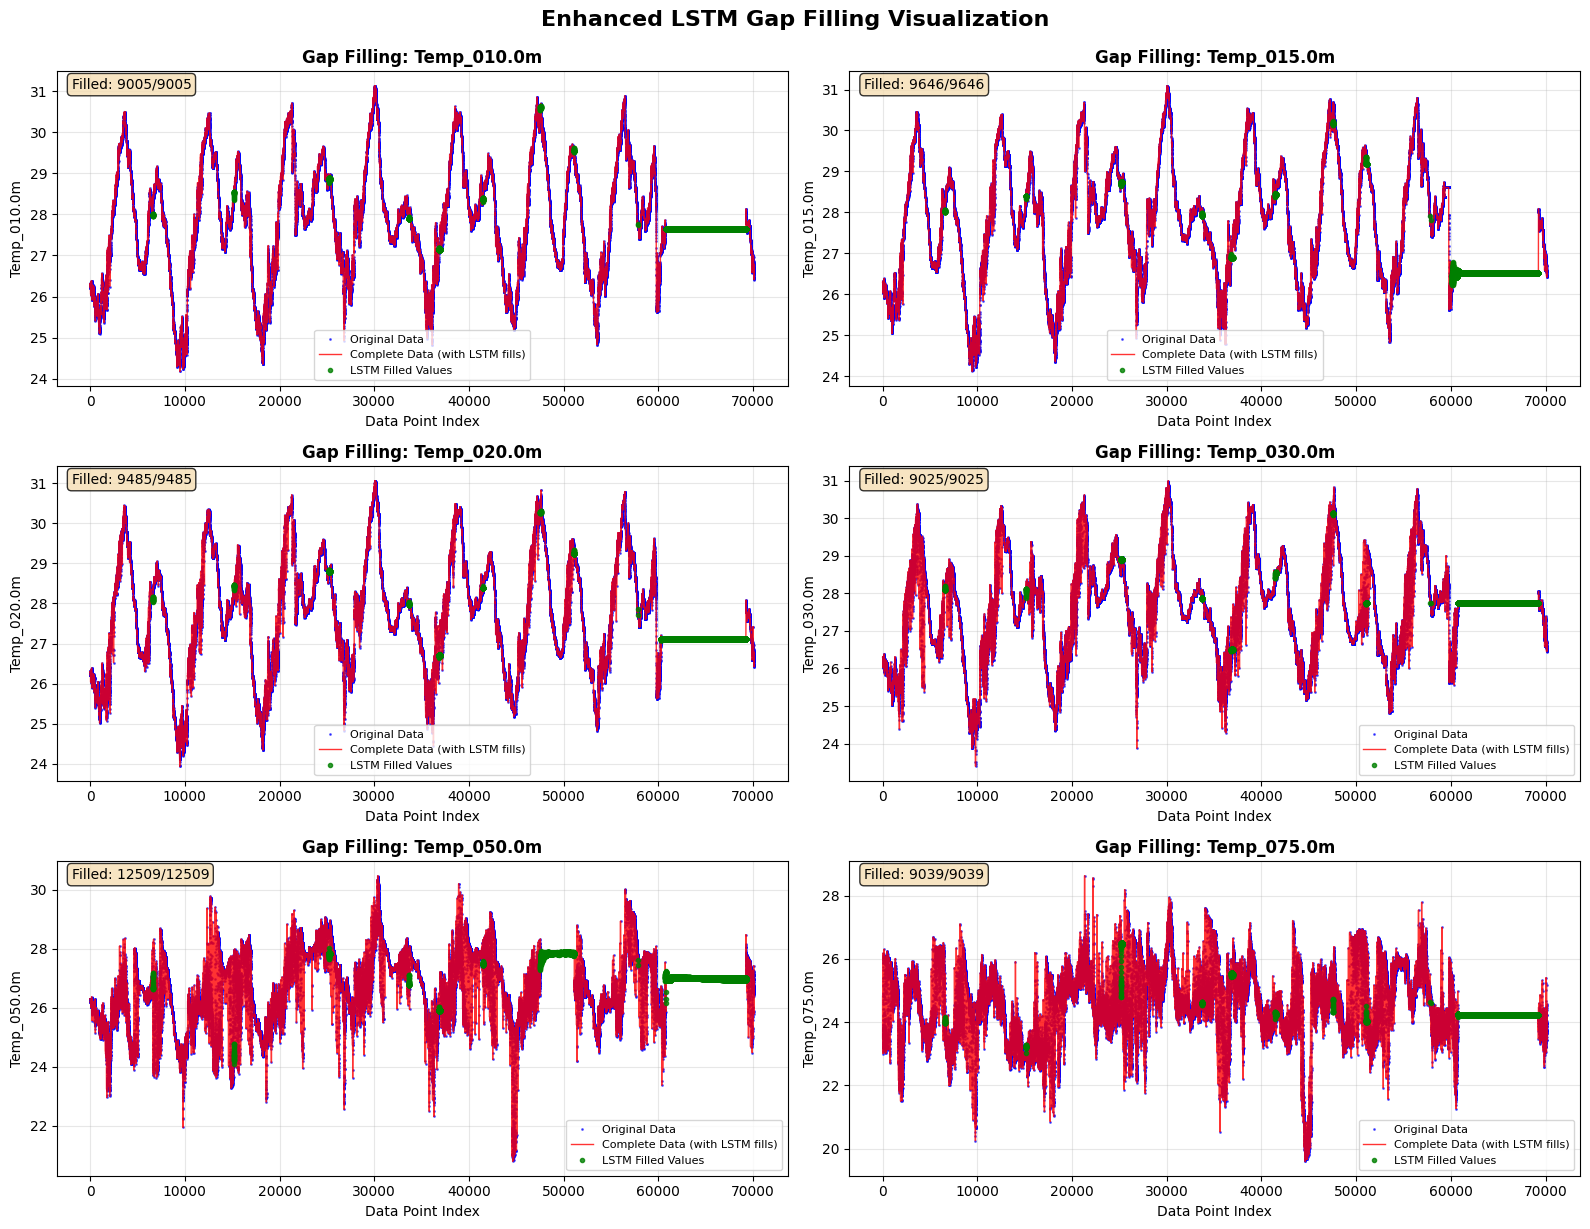

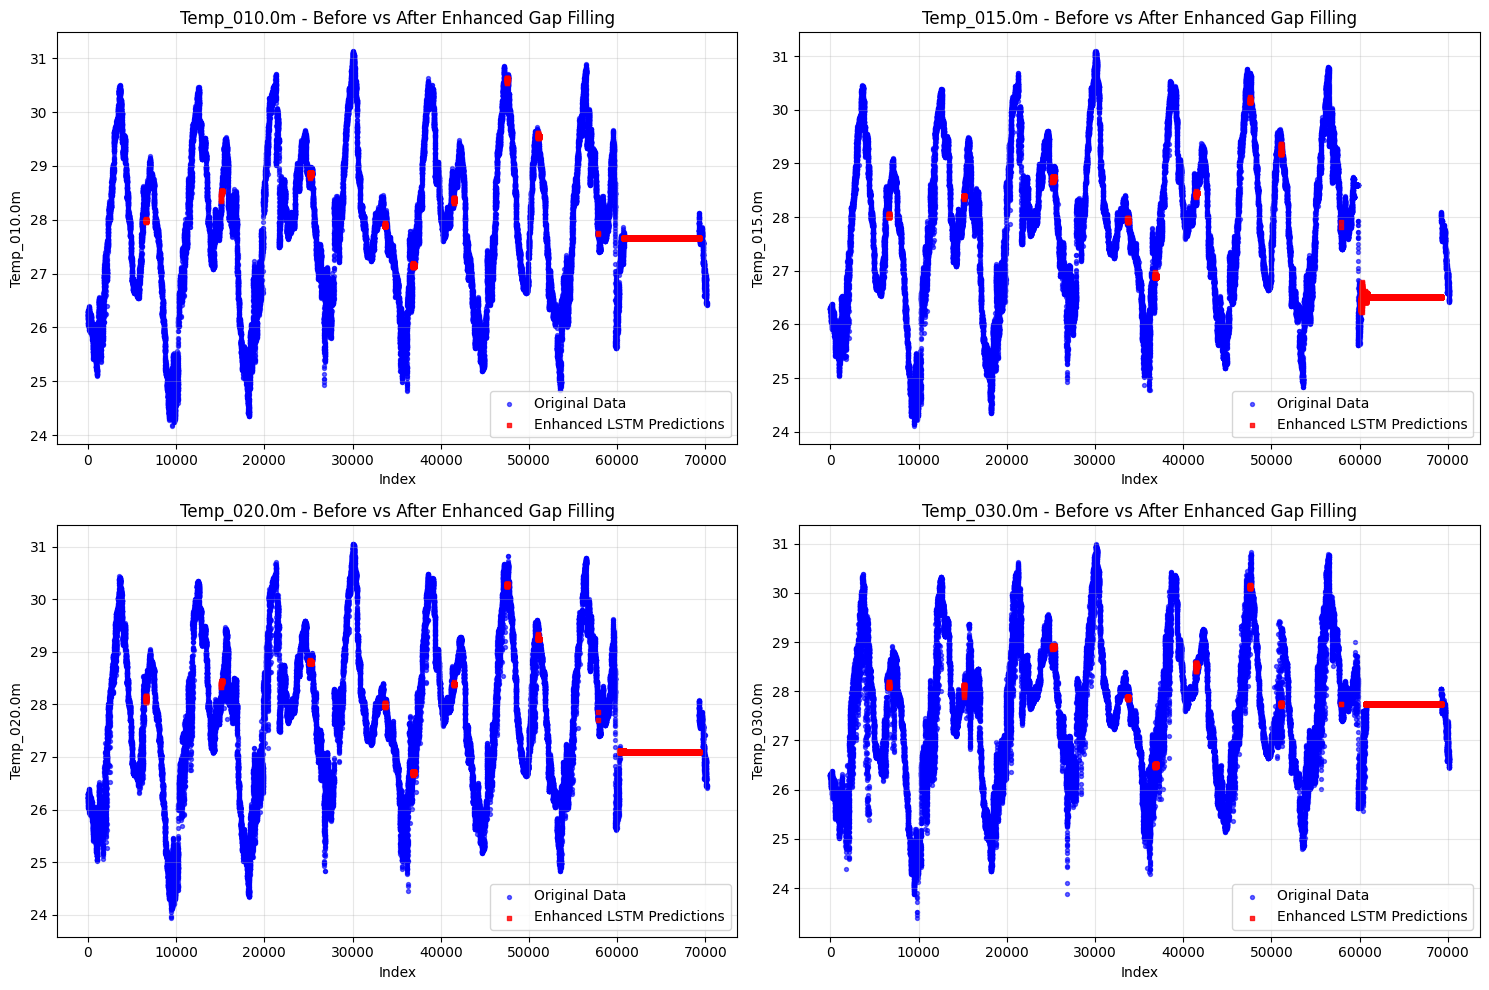

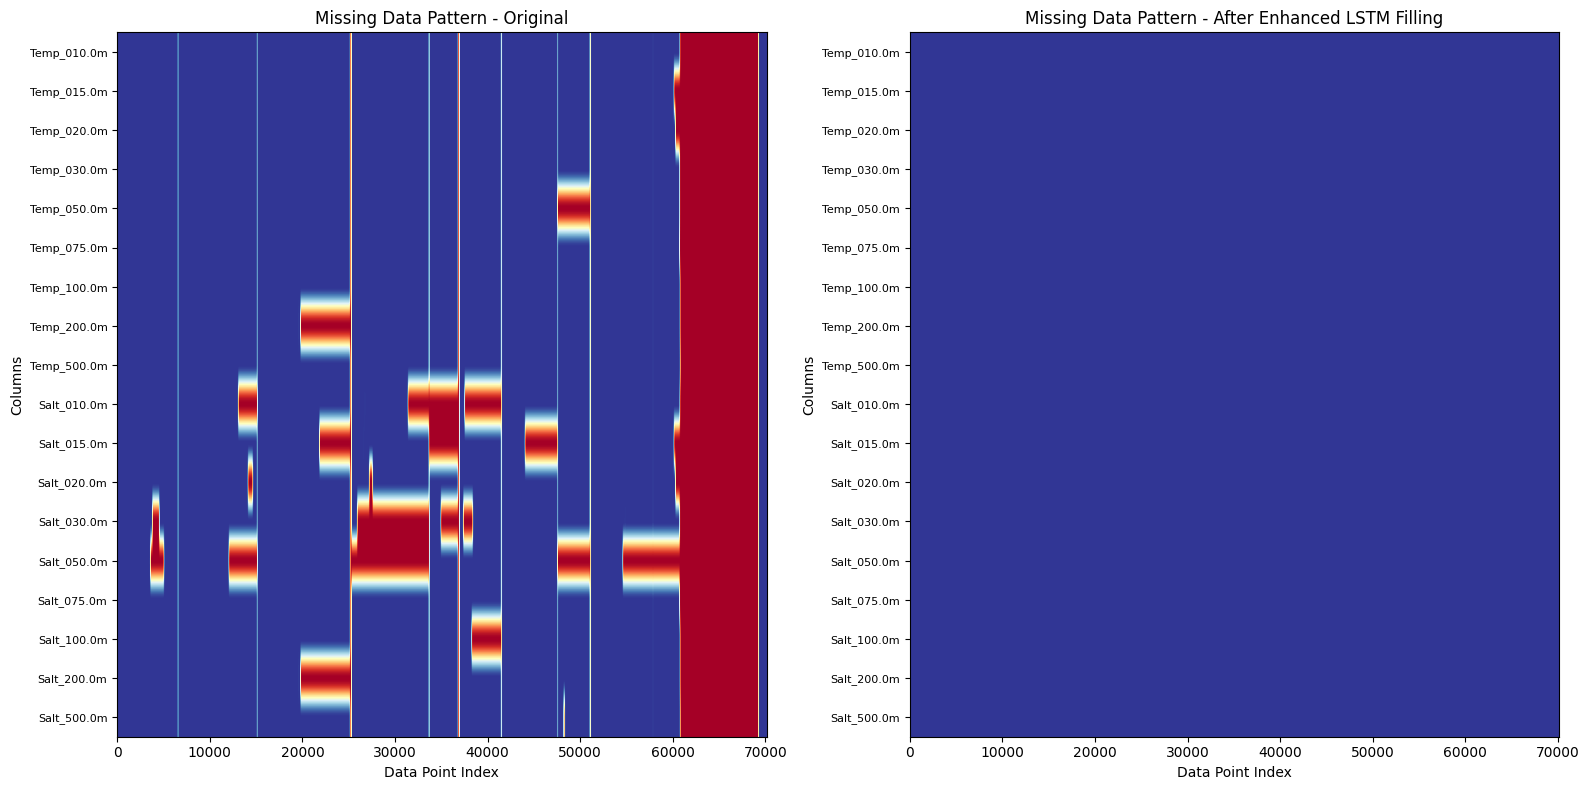

Enhanced LSTM Missing Data Summary:
Original missing values: 237802
Remaining missing values: 0
Fill rate: 100.0%
Visualization completed!


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_idx, sequence_length):
        self.data = data
        self.target_idx = target_idx
        self.sequence_length = sequence_length
        self.X, self.y = self.create_sequences()

    def create_sequences(self):
        X, y = [], []
        step_size = max(1, self.sequence_length // 6)
        
        for i in range(self.sequence_length, len(self.data), step_size):
            X.append(self.data[i-self.sequence_length:i])
            y.append(self.data[i, self.target_idx])
            
        return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, lstm_units=128, sequence_length=24):
        super(EnhancedLSTM, self).__init__()
        self.lstm_units = lstm_units
        
        self.lstm1 = nn.LSTM(input_size, lstm_units, batch_first=True, dropout=0.2, bidirectional=True)
        self.lstm2 = nn.LSTM(lstm_units*2, lstm_units, batch_first=True, dropout=0.2, bidirectional=True)
        self.lstm3 = nn.LSTM(lstm_units*2, lstm_units//2, batch_first=True, dropout=0.2)
        
        self.bn1 = nn.BatchNorm1d(lstm_units//2)
        
        self.fc1 = nn.Linear(lstm_units//2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]
        out = self.bn1(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        
        return out.squeeze()

def create_enhanced_features(df, target_column):
    df_enhanced = df.copy()
    
    if 'Time[UTC]' in df.columns:
        df_enhanced['hour'] = pd.to_datetime(df['Time[UTC]']).dt.hour
        df_enhanced['day_of_year'] = pd.to_datetime(df['Time[UTC]']).dt.dayofyear
    
    feature_cols = [col for col in df.columns if col not in ['Time[UTC]', target_column]]
    
    for col in feature_cols:
        df_enhanced[f'{col}_rolling_mean_6'] = df[col].rolling(window=6, min_periods=1).mean()
        df_enhanced[f'{col}_rolling_mean_12'] = df[col].rolling(window=12, min_periods=1).mean()
        df_enhanced[f'{col}_rolling_std_6'] = df[col].rolling(window=6, min_periods=1).std()
        df_enhanced[f'{col}_lag_1'] = df[col].shift(1)
        df_enhanced[f'{col}_lag_3'] = df[col].shift(3)
        df_enhanced[f'{col}_lag_6'] = df[col].shift(6)
        df_enhanced[f'{col}_diff_1'] = df[col].diff(1)
        df_enhanced[f'{col}_ema_6'] = df[col].ewm(span=6).mean()
    
    temp_cols = [col for col in feature_cols if 'Temp_' in col]
    salt_cols = [col for col in feature_cols if 'Salt_' in col]
    
    for i in range(len(temp_cols)-1):
        df_enhanced[f'temp_gradient_{i}'] = df[temp_cols[i]] - df[temp_cols[i+1]]
    
    for i in range(len(salt_cols)-1):
        df_enhanced[f'salt_gradient_{i}'] = df[salt_cols[i]] - df[salt_cols[i+1]]
    
    return df_enhanced

class EnhancedLSTMImputer:
    def __init__(self, sequence_length=24, lstm_units=128):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.scaler = StandardScaler()
        self.model = None
        self.device = device
        
    def prepare_data_enhanced(self, df, target_column):
        df_enhanced = create_enhanced_features(df, target_column)
        
        feature_cols = [col for col in df_enhanced.columns if col != 'Time[UTC]']
        
        df_filled = df_enhanced[feature_cols].copy()
        df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')
        df_filled = df_filled.interpolate(method='linear')
        df_filled = df_filled.fillna(df_filled.mean())
        
        scaled_data = self.scaler.fit_transform(df_filled)
        target_idx = list(df_filled.columns).index(target_column)
        
        return scaled_data, target_idx, list(df_filled.columns)
    
    def train_enhanced(self, df, target_column, epochs=60, batch_size=64):
        print(f"Training enhanced LSTM model for {target_column}...")
        
        scaled_data, target_idx, feature_cols = self.prepare_data_enhanced(df, target_column)
        
        print(f"Enhanced features created: {len(feature_cols)} features")
        
        dataset = TimeSeriesDataset(scaled_data, target_idx, self.sequence_length)
        
        if len(dataset) == 0:
            print("ERROR: No training sequences created!")
            return None
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"Training sequences: {len(dataset)}, Features: {len(feature_cols)}")
        
        self.model = EnhancedLSTM(len(feature_cols), self.lstm_units, self.sequence_length)
        self.model.to(self.device)
        
        criterion = nn.HuberLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.5)
        
        best_val_loss = float('inf')
        patience = 12
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                    val_outputs = self.model(X_val)
                    val_loss += criterion(val_outputs, y_val).item()
            
            avg_val_loss = val_loss / len(val_loader)
            scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), f'enhanced_model_{target_column}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    self.model.load_state_dict(torch.load(f'enhanced_model_{target_column}.pth'))
                    break
            
            if (epoch + 1) % 15 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}')
        
        print(f"Enhanced training completed. Best val loss: {best_val_loss:.4f}")
        return True
    
    def predict_gaps_enhanced(self, df, target_column):
        print(f"Enhanced gap filling for {target_column}...")
        
        if self.model is None:
            print("ERROR: Model not trained!")
            return df
        
        df_filled = df.copy()
        
        df_enhanced = create_enhanced_features(df, target_column)
        feature_cols = [col for col in df_enhanced.columns if col != 'Time[UTC]']
        
        missing_mask = df[target_column].isnull()
        missing_indices = df[missing_mask].index.tolist()
        
        print(f"Found {len(missing_indices)} missing values to fill")
        
        if len(missing_indices) == 0:
            return df_filled
        
        df_enhanced_filled = df_enhanced[feature_cols].copy()
        df_enhanced_filled = df_enhanced_filled.fillna(method='ffill').fillna(method='bfill')
        df_enhanced_filled = df_enhanced_filled.interpolate(method='linear')
        df_enhanced_filled = df_enhanced_filled.fillna(df_enhanced_filled.mean())
        
        filled_count = 0
        self.model.eval()
        
        with torch.no_grad():
            for idx in missing_indices:
                if idx >= self.sequence_length:
                    start_idx = idx - self.sequence_length
                    sequence_data = df_enhanced_filled.iloc[start_idx:idx].copy()
                    
                    try:
                        sequence_scaled = self.scaler.transform(sequence_data)
                        sequence_tensor = torch.tensor(sequence_scaled, dtype=torch.float32).unsqueeze(0).to(self.device)
                        
                        prediction_scaled = self.model(sequence_tensor).cpu().item()
                        
                        dummy_array = np.zeros((1, len(feature_cols)))
                        target_idx = feature_cols.index(target_column)
                        dummy_array[0, target_idx] = prediction_scaled
                        
                        prediction_actual = self.scaler.inverse_transform(dummy_array)[0, target_idx]
                        
                        if target_column.startswith('Temp_'):
                            prediction_actual = np.clip(prediction_actual, -2, 35)
                        elif target_column.startswith('Salt_'):
                            prediction_actual = np.clip(prediction_actual, 30, 42)
                        
                        df_filled.loc[idx, target_column] = prediction_actual
                        df_enhanced_filled.loc[idx, target_column] = prediction_actual
                        filled_count += 1
                        
                    except Exception as e:
                        continue
        
        print(f"Enhanced filling: {filled_count}/{len(missing_indices)} values filled")
        return df_filled

def enhanced_gap_filling(df):
    print("ENHANCED LSTM GAP FILLING STARTED")
    print("="*60)
    print("Using: 3-Layer Bidirectional LSTM + Sequence Length 24 + Enhanced Features")
    print("="*60)
    
    missing_counts = df.isnull().sum()
    columns_with_missing = missing_counts[missing_counts > 0]
    columns_with_missing = columns_with_missing[columns_with_missing.index != 'Time[UTC]']
    columns_to_fill = columns_with_missing.sort_values().index.tolist()
    
    print("Columns to process:")
    for col in columns_to_fill:
        print(f"  {col}: {missing_counts[col]} missing values")
    print("\n" + "="*60)
    
    df_result = df.copy()
    
    for column in columns_to_fill:
        print(f"\nProcessing: {column}")
        print("-" * 40)
        
        imputer = EnhancedLSTMImputer(sequence_length=24, lstm_units=128)
        
        success = imputer.train_enhanced(df_result, column, epochs=60)
        
        if success:
            df_result = imputer.predict_gaps_enhanced(df_result, column)
            
            remaining = df_result[column].isnull().sum()
            filled = missing_counts[column] - remaining
            fill_rate = (filled / missing_counts[column]) * 100
            
            print(f"Results: {filled}/{missing_counts[column]} filled ({fill_rate:.1f}%)")
        else:
            print(f"Failed to process {column}")
        
        print("-" * 40)
    
    return df_result

def visualize_gap_filling(df_original, df_filled):
    columns_to_visualize = [col for col in df_original.columns if col != 'Time[UTC]' and df_original[col].isnull().sum() > 0][:6]
    
    if len(columns_to_visualize) == 0:
        print("No columns with missing values found!")
        return
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(columns_to_visualize):
        if i < len(axes):
            missing_mask = df_original[col].isnull()
            
            axes[i].plot(df_original.index, df_original[col], 'b.', alpha=0.6, markersize=2, label='Original Data')
            axes[i].plot(df_filled.index, df_filled[col], 'r-', alpha=0.8, linewidth=1, label='Complete Data (with LSTM fills)')
            
            if missing_mask.any():
                filled_indices = df_original.index[missing_mask]
                filled_values = df_filled.loc[missing_mask, col]
                axes[i].plot(filled_indices, filled_values, 'go', markersize=3, alpha=0.8, label='LSTM Filled Values')
            
            axes[i].set_title(f'Gap Filling: {col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Data Point Index')
            axes[i].set_ylabel(col)
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
            
            missing_count = df_original[col].isnull().sum()
            filled_count = missing_count - df_filled[col].isnull().sum()
            axes[i].text(0.02, 0.98, f'Filled: {filled_count}/{missing_count}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Enhanced LSTM Gap Filling Visualization', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def visualize_before_after_comparison(df_original, df_filled):
    columns_to_visualize = [col for col in df_original.columns if col != 'Time[UTC]' and df_original[col].isnull().sum() > 0][:4]
    
    if len(columns_to_visualize) == 0:
        print("No columns with missing values found!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(columns_to_visualize):
        if i < len(axes):
            missing_mask = df_original[col].isnull()
            
            axes[i].scatter(df_original.index[~missing_mask], df_original[col][~missing_mask], 
                           color='blue', s=8, alpha=0.6, label='Original Data')
            
            if missing_mask.any():
                axes[i].scatter(df_original.index[missing_mask], df_filled[col][missing_mask], 
                               color='red', s=12, alpha=0.8, label='Enhanced LSTM Predictions', marker='s')
            
            axes[i].set_title(f'{col} - Before vs After Enhanced Gap Filling')
            axes[i].set_xlabel('Index')
            axes[i].set_ylabel(col)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_missing_data_heatmap(df_original, df_filled):
    numeric_cols = [col for col in df_original.columns if col != 'Time[UTC]']
    
    if len(numeric_cols) == 0:
        print("No numeric columns found!")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    missing_original = df_original[numeric_cols].isnull()
    missing_filled = df_filled[numeric_cols].isnull()
    
    im1 = ax1.imshow(missing_original.T, cmap='RdYlBu_r', aspect='auto')
    ax1.set_title('Missing Data Pattern - Original')
    ax1.set_xlabel('Data Point Index')
    ax1.set_ylabel('Columns')
    ax1.set_yticks(range(len(numeric_cols)))
    ax1.set_yticklabels(numeric_cols, fontsize=8)
    
    im2 = ax2.imshow(missing_filled.T, cmap='RdYlBu_r', aspect='auto')
    ax2.set_title('Missing Data Pattern - After Enhanced LSTM Filling')
    ax2.set_xlabel('Data Point Index')
    ax2.set_ylabel('Columns')
    ax2.set_yticks(range(len(numeric_cols)))
    ax2.set_yticklabels(numeric_cols, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    original_missing = df_original[numeric_cols].isnull().sum().sum()
    remaining_missing = df_filled[numeric_cols].isnull().sum().sum()
    
    print("Enhanced LSTM Missing Data Summary:")
    print(f"Original missing values: {original_missing}")
    print(f"Remaining missing values: {remaining_missing}")
    if original_missing > 0:
        fill_rate = ((original_missing - remaining_missing) / original_missing * 100)
        print(f"Fill rate: {fill_rate:.1f}%")

if __name__ == "__main__":
    print("INITIAL MISSING VALUES:")
    print(df.isnull().sum())
    print("\n" + "="*60)
    
    df_enhanced_filled = enhanced_gap_filling(df)
    
    print("\n" + "="*60)
    print("FINAL RESULTS:")
    print("="*60)
    print("Remaining missing values:")
    print(df_enhanced_filled.isnull().sum())
    
    print("\nACCURACY ANALYSIS:")
    print("-" * 30)
    
    total_accuracy = 0
    count = 0
    total_filled = 0
    total_missing = 0
    
    for column in df.columns:
        if column != 'Time[UTC]' and df[column].isnull().sum() > 0:
            original_missing = df[column].isnull().sum()
            remaining_missing = df_enhanced_filled[column].isnull().sum()
            filled_count = original_missing - remaining_missing
            
            total_filled += filled_count
            total_missing += original_missing
            
            if filled_count > 0:
                orig_mean = df[column].mean()
                filled_values = df_enhanced_filled[df[column].isnull()][column]
                
                if len(filled_values) > 0 and not filled_values.isnull().all():
                    filled_mean = filled_values.mean()
                    if not np.isnan(filled_mean) and not np.isnan(orig_mean) and orig_mean != 0:
                        diff = abs(orig_mean - filled_mean) / orig_mean * 100
                        accuracy = 100 - diff
                        total_accuracy += accuracy
                        count += 1
                        print(f"{column}: {accuracy:.1f}% accuracy, {filled_count}/{original_missing} filled")
                    else:
                        print(f"{column}: {filled_count}/{original_missing} filled")
                else:
                    print(f"{column}: No valid fills")
            else:
                print(f"{column}: 0/{original_missing} filled")
    
    overall_accuracy = total_accuracy / count if count > 0 else 0
    overall_fill_rate = (total_filled / total_missing) * 100 if total_missing > 0 else 0
    
    print("\n" + "="*60)
    print("FINAL SUMMARY:")
    print(f"Overall Fill Rate: {overall_fill_rate:.1f}% ({total_filled}/{total_missing})")
    print(f"Overall Accuracy: {overall_accuracy:.1f}%")
    print("="*60)
    
    df_enhanced_filled.to_excel('enhanced_lstm_oceanographic_filled.xlsx', index=False)
    print("\nEnhanced LSTM gap filling completed and saved!")
    print("File saved as: enhanced_lstm_oceanographic_filled.xlsx")
    
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS...")
    print("="*60)
    
    visualize_gap_filling(df, df_enhanced_filled)
    visualize_before_after_comparison(df, df_enhanced_filled)
    plot_missing_data_heatmap(df, df_enhanced_filled)
    
    print("Visualization completed!")


In [13]:
    df_enhanced_filled.to_csv('enhanced_lstm_oceanographic_filled.csv', index=False)
    print("saved!")

saved!


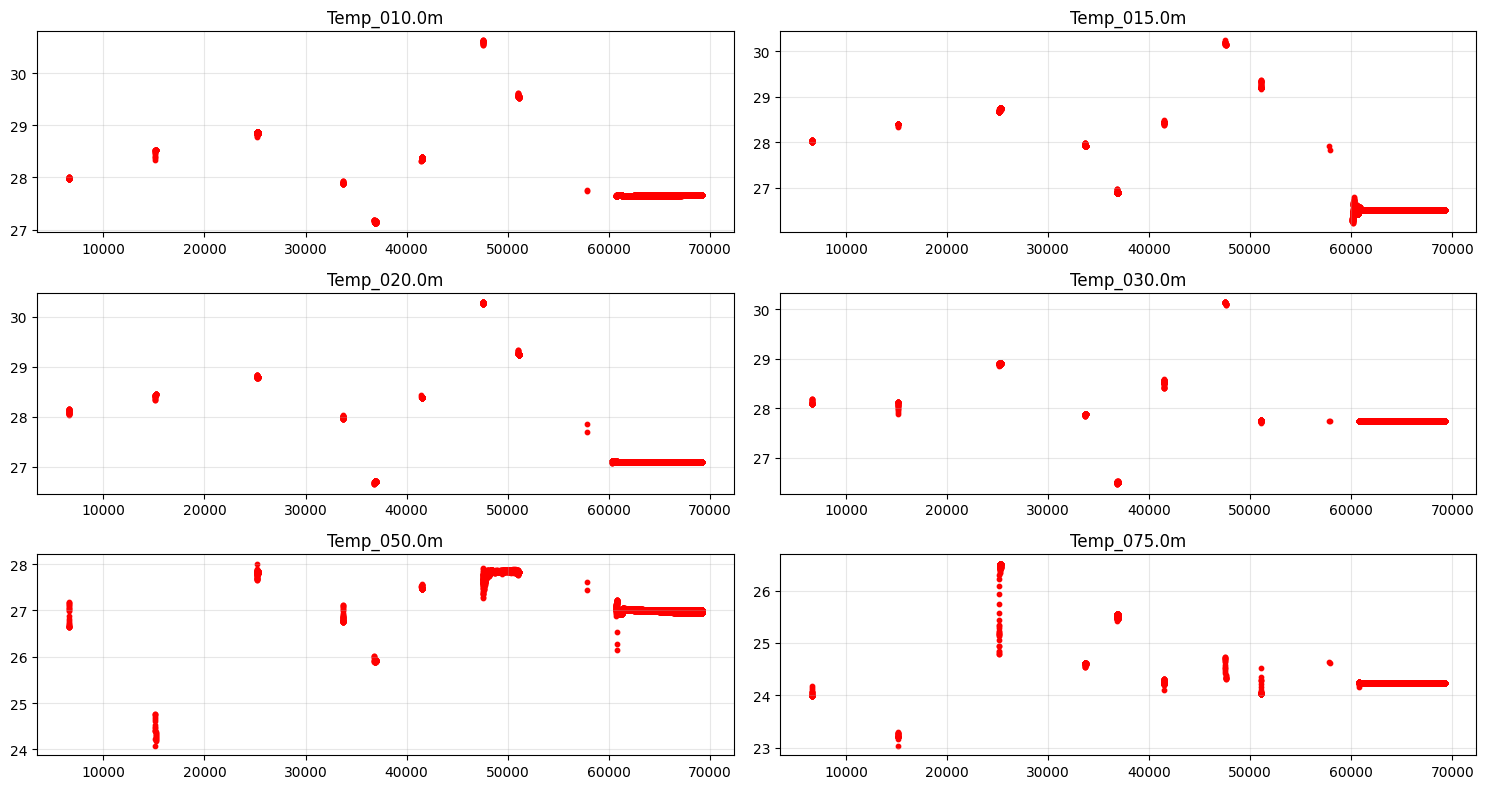

In [27]:
import matplotlib.pyplot as plt

def plot_filled_gaps(df_original, df_filled):
    cols = [col for col in df_original.columns if col != 'Time[UTC]' and df_original[col].isnull().sum() > 0][:6]
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, col in enumerate(cols):
        missing_mask = df_original[col].isnull()
        filled_values = df_filled.loc[missing_mask, col]
        
        axes[i].scatter(missing_mask.index[missing_mask], filled_values, color='red', s=10)
        axes[i].set_title(f'{col}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_filled_gaps(df, df_enhanced_filled)


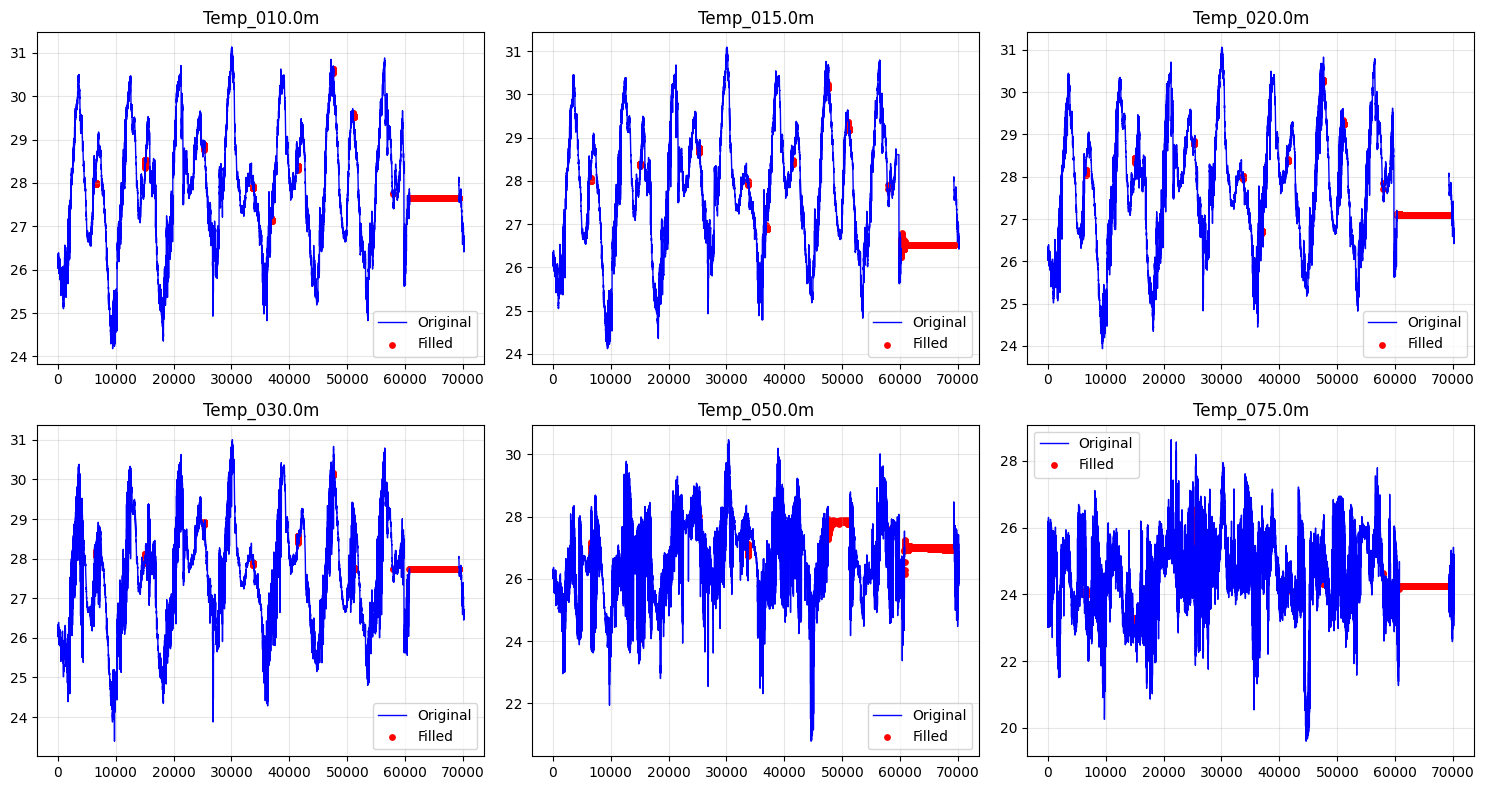

In [33]:
import matplotlib.pyplot as plt

def plot_original_and_filled(df_original, df_filled):
    cols = [col for col in df_original.columns if col != 'Time[UTC]' and df_original[col].isnull().sum() > 0][:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, col in enumerate(cols):
        axes[i].plot(df_original.index, df_original[col], 'b-', linewidth=1, label='Original')
        
        missing_mask = df_original[col].isnull()
        filled_values = df_filled.loc[missing_mask, col]
        axes[i].scatter(missing_mask.index[missing_mask], filled_values, color='red', s=15, label='Filled')
        
        axes[i].set_title(f'{col}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_original_and_filled(df, df_enhanced_filled)


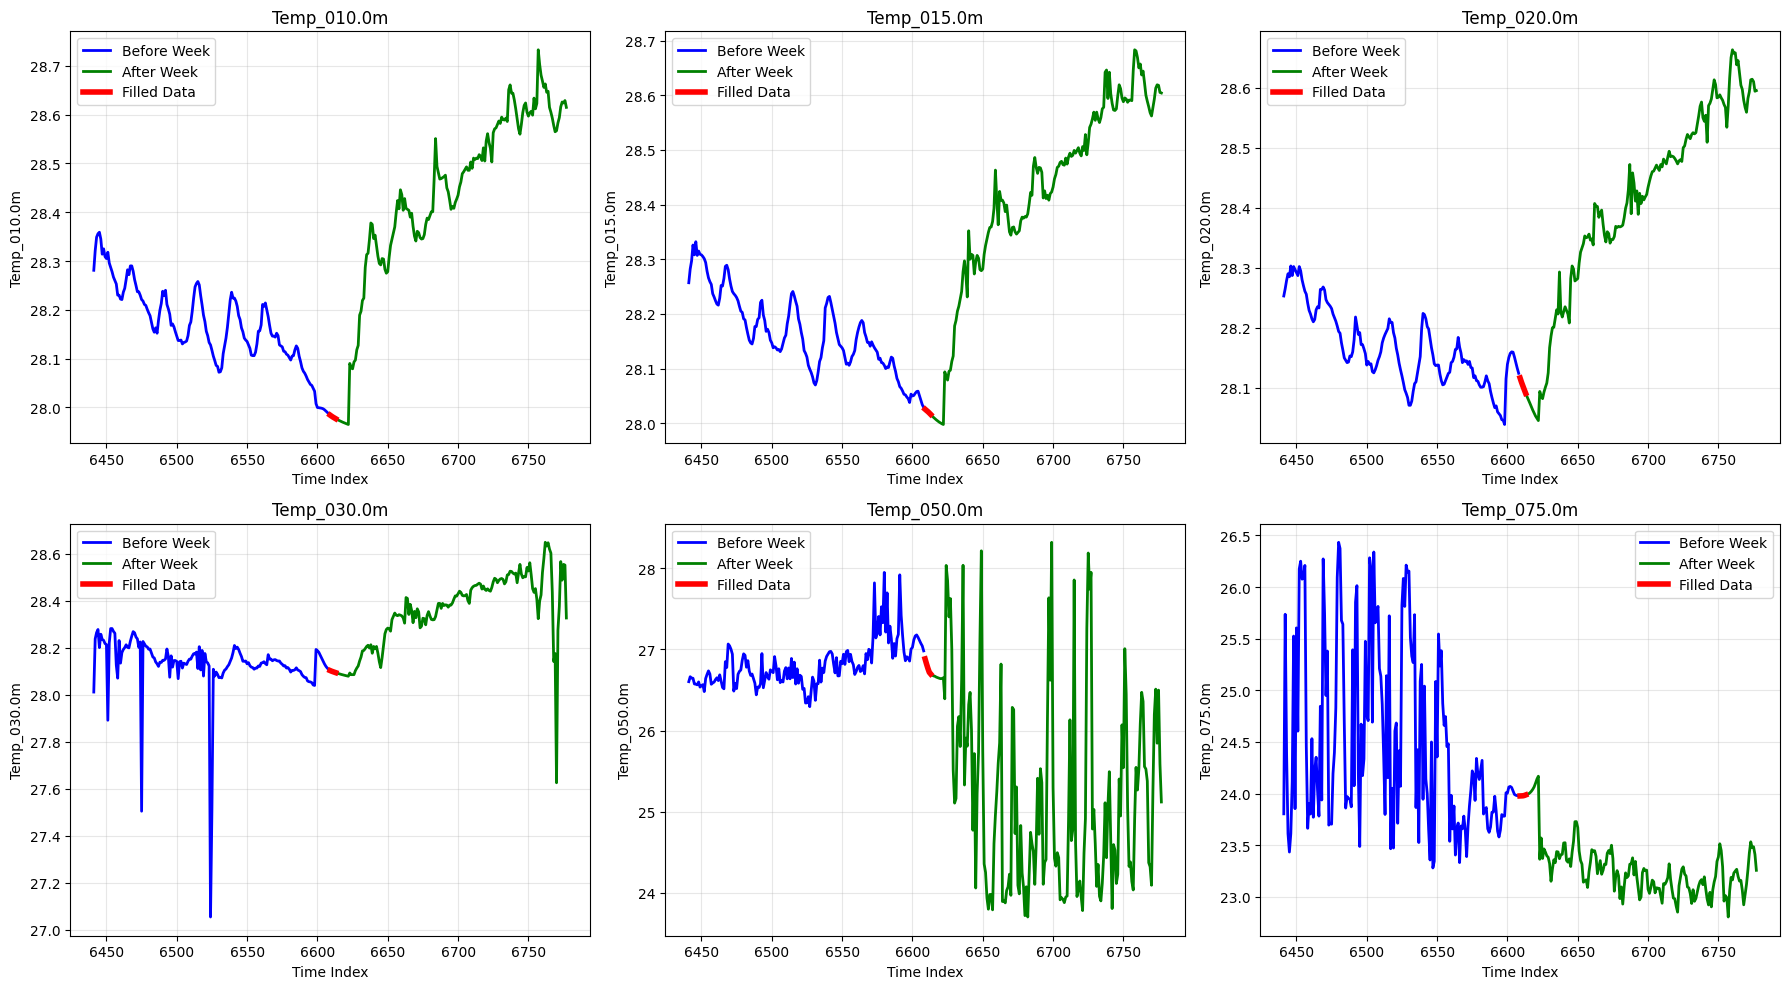

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_filled_with_context(df_original, df_filled):
    cols = [col for col in df_original.columns if col != 'Time[UTC]' and df_original[col].isnull().sum() > 0]
    
    if 'Time[UTC]' in df_original.columns:
        df_original['Time[UTC]'] = pd.to_datetime(df_original['Time[UTC]'])
    
    time_window = 7 * 24
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(cols[:6]):
        filled_positions = df_original.index[df_original[col].isnull()]
        
        if len(filled_positions) > 0:
            center_pos = filled_positions[min(10, len(filled_positions)-1)]
            
            start_idx = max(0, center_pos - time_window)
            end_idx = min(len(df_original) - 1, center_pos + time_window)
            
            before_range = list(range(start_idx, center_pos))
            filled_range = list(range(center_pos, center_pos + 5))  # Multiple points for line
            after_range = list(range(center_pos + 5, end_idx + 1))
            
            if len(before_range) > 0:
                axes[i].plot(before_range, df_filled.iloc[before_range][col], 
                           color='blue', linewidth=2, label='Before Week')
            
            if len(after_range) > 0:
                axes[i].plot(after_range, df_filled.iloc[after_range][col], 
                           color='green', linewidth=2, label='After Week')
            
            if len(filled_range) > 0:
                axes[i].plot(filled_range, df_filled.iloc[filled_range][col], 
                            color='red', linewidth=4, label='Filled Data', zorder=5)
            
            axes[i].set_title(f'{col}')
            axes[i].set_xlabel('Time Index')
            axes[i].set_ylabel(col)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'No missing data', ha='center', va='center', 
                        transform=axes[i].transAxes)
            axes[i].set_title(f'{col} - No gaps')
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_filled_with_context(df, df_enhanced_filled)


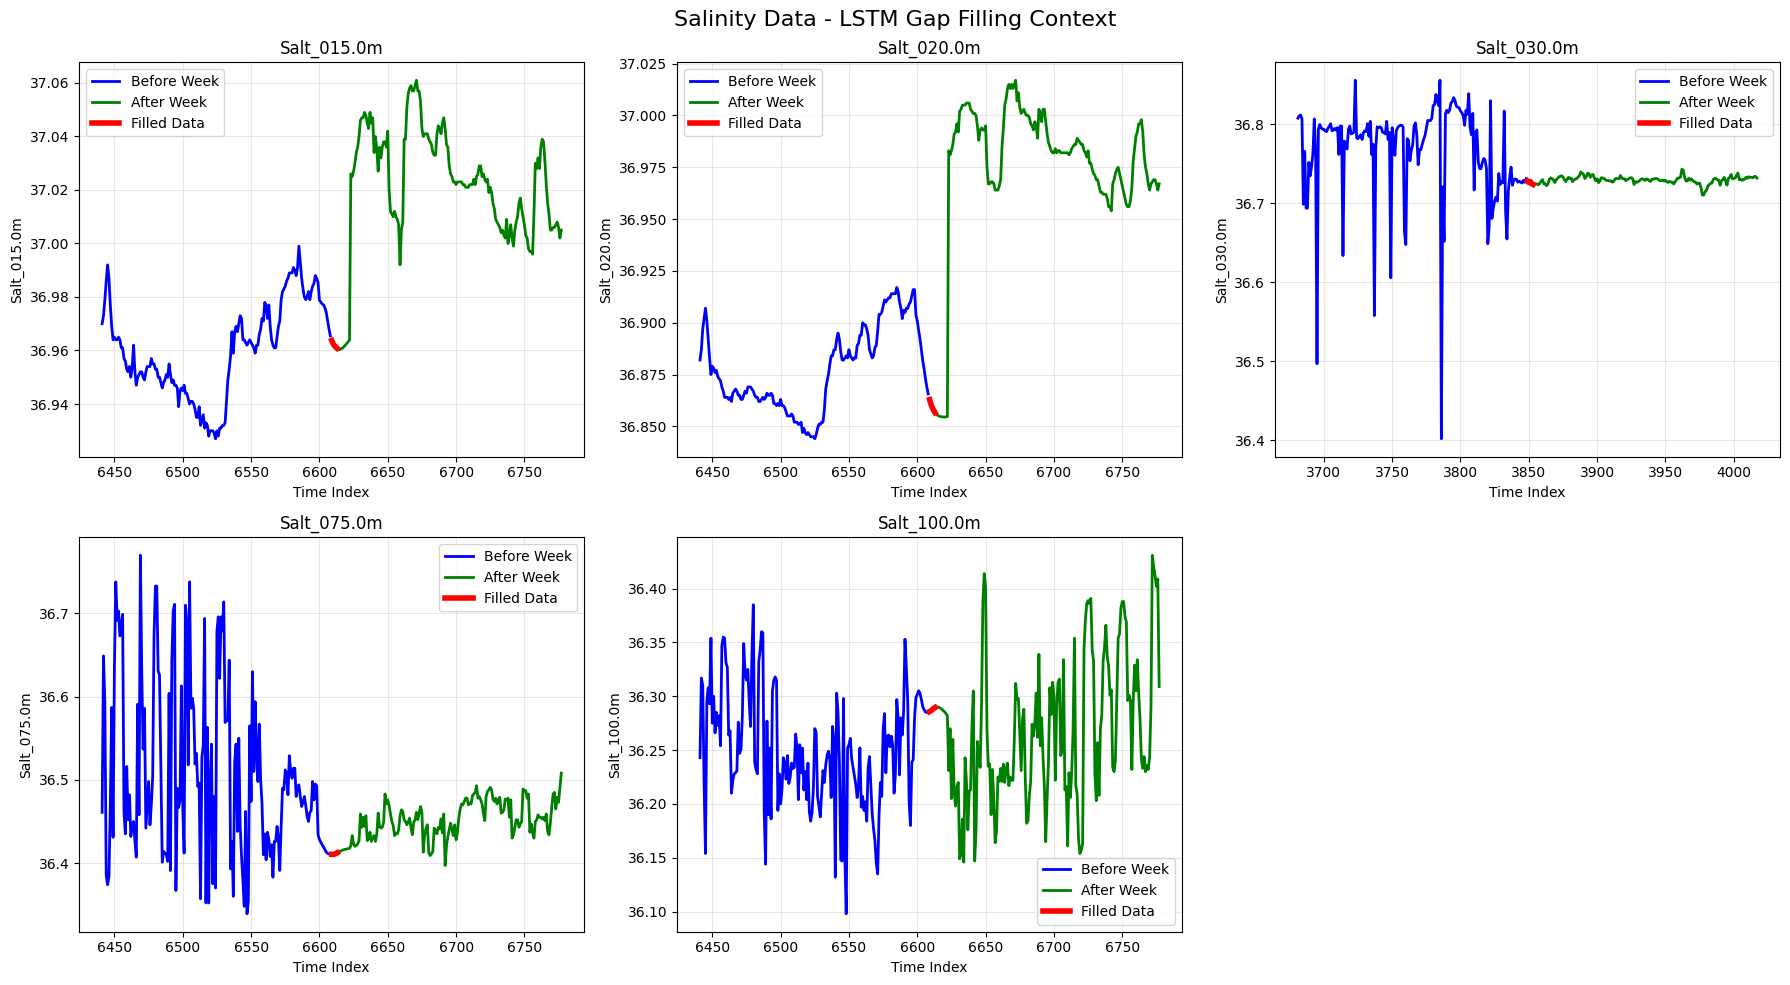

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_filled_with_context_salinity(df_original, df_filled):
    salt_cols = ['Salt_015.0m', 'Salt_020.0m', 'Salt_030.0m', 'Salt_075.0m', 'Salt_100.0m']
    
    if 'Time[UTC]' in df_original.columns:
        df_original['Time[UTC]'] = pd.to_datetime(df_original['Time[UTC]'])
    
    time_window = 7 * 24
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(salt_cols):
        filled_positions = df_original.index[df_original[col].isnull()]
        
        if len(filled_positions) > 0:
            center_pos = filled_positions[min(10, len(filled_positions)-1)]
            
            start_idx = max(0, center_pos - time_window)
            end_idx = min(len(df_original) - 1, center_pos + time_window)
            
            before_range = list(range(start_idx, center_pos))
            filled_range = list(range(center_pos, center_pos + 5))
            after_range = list(range(center_pos + 5, end_idx + 1))
            
            if len(before_range) > 0:
                axes[i].plot(before_range, df_filled.iloc[before_range][col], 
                           color='blue', linewidth=2, label='Before Week')
            
            if len(after_range) > 0:
                axes[i].plot(after_range, df_filled.iloc[after_range][col], 
                           color='green', linewidth=2, label='After Week')
            
            if len(filled_range) > 0:
                axes[i].plot(filled_range, df_filled.iloc[filled_range][col], 
                            color='red', linewidth=4, label='Filled Data', zorder=5)
            
            axes[i].set_title(f'{col}')
            axes[i].set_xlabel('Time Index')
            axes[i].set_ylabel(col)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'No missing data', ha='center', va='center', 
                        transform=axes[i].transAxes)
            axes[i].set_title(f'{col} - No gaps')
    
    axes[5].set_visible(False)
    
    plt.suptitle('Salinity Data - LSTM Gap Filling Context', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_filled_with_context_salinity(df, df_enhanced_filled)


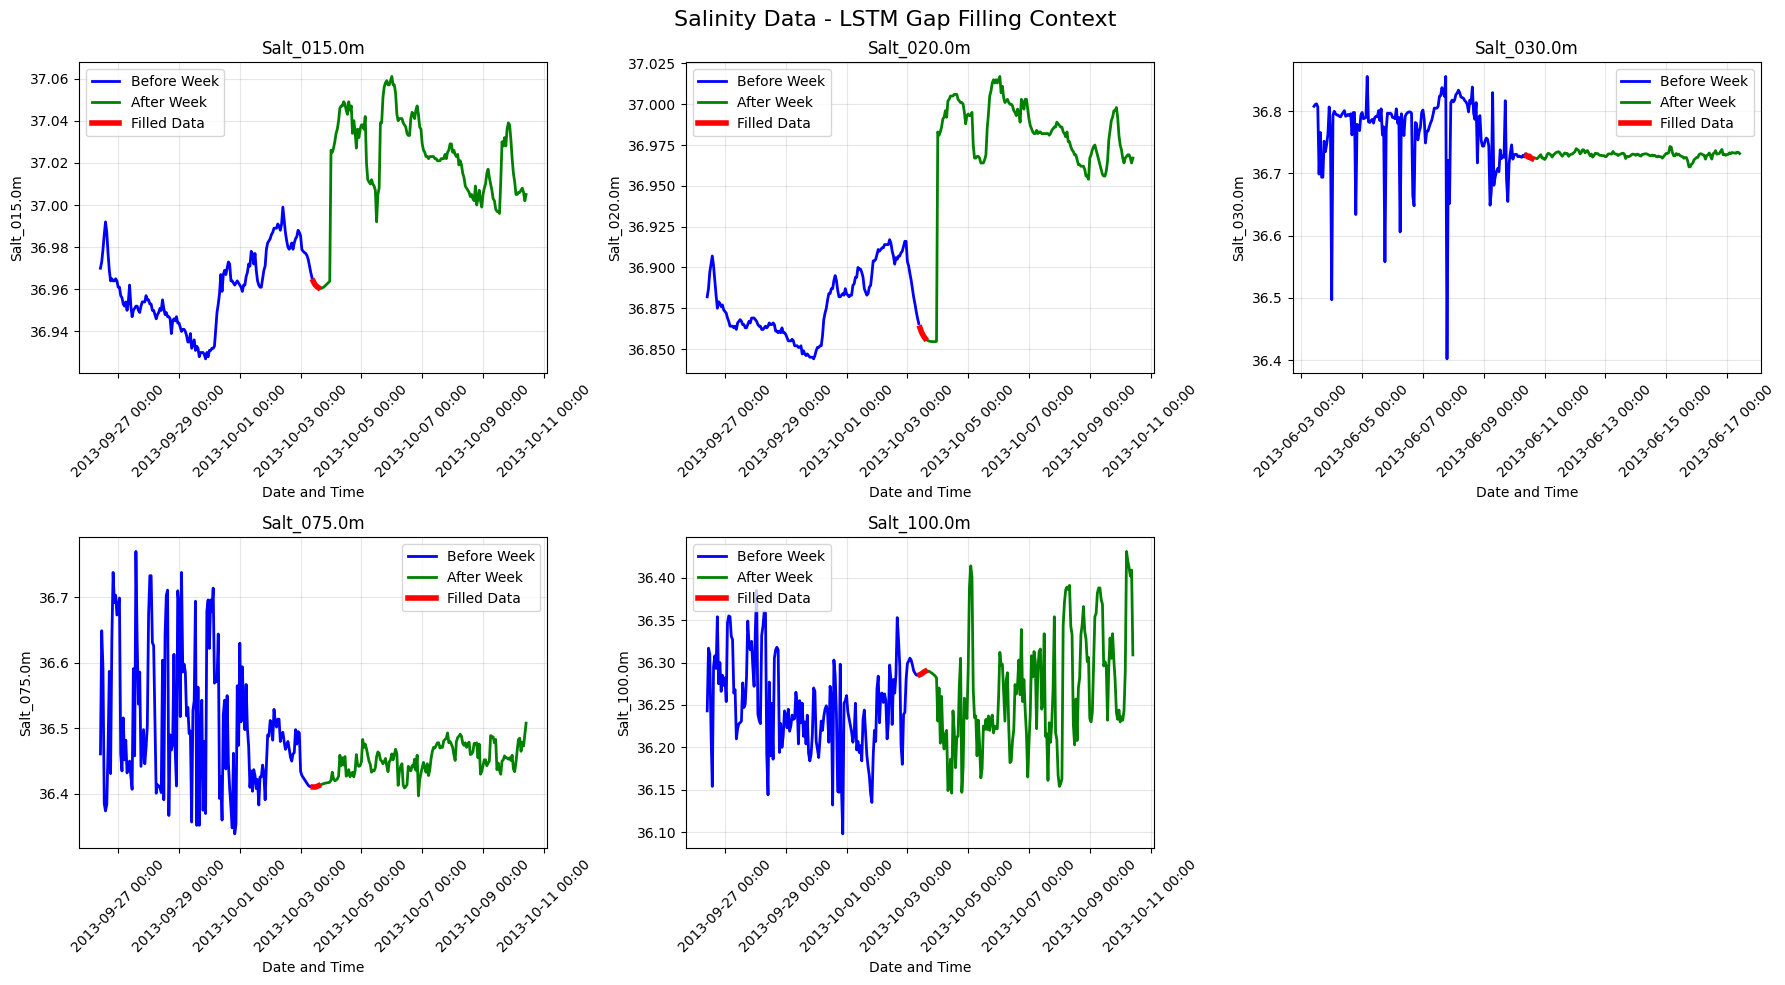

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_filled_with_context_salinity(df_original, df_filled):
    salt_cols = ['Salt_015.0m', 'Salt_020.0m', 'Salt_030.0m', 'Salt_075.0m', 'Salt_100.0m']
    
    if 'Time[UTC]' in df_original.columns:
        df_original['Time[UTC]'] = pd.to_datetime(df_original['Time[UTC]'])
        df_filled['Time[UTC]'] = pd.to_datetime(df_filled['Time[UTC]'])
    
    time_window = 7 * 24
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(salt_cols):
        filled_positions = df_original.index[df_original[col].isnull()]
        
        if len(filled_positions) > 0:
            center_pos = filled_positions[min(10, len(filled_positions)-1)]
            
            start_idx = max(0, center_pos - time_window)
            end_idx = min(len(df_original) - 1, center_pos + time_window)
            
            before_range = list(range(start_idx, center_pos))
            filled_range = list(range(center_pos, center_pos + 5))
            after_range = list(range(center_pos + 5, end_idx + 1))
            
            if len(before_range) > 0:
                axes[i].plot(df_filled.iloc[before_range]['Time[UTC]'], df_filled.iloc[before_range][col], 
                           color='blue', linewidth=2, label='Before Week')
            
            if len(after_range) > 0:
                axes[i].plot(df_filled.iloc[after_range]['Time[UTC]'], df_filled.iloc[after_range][col], 
                           color='green', linewidth=2, label='After Week')
            
            if len(filled_range) > 0:
                axes[i].plot(df_filled.iloc[filled_range]['Time[UTC]'], df_filled.iloc[filled_range][col], 
                            color='red', linewidth=4, label='Filled Data', zorder=5)
            
            axes[i].set_title(f'{col}')
            axes[i].set_xlabel('Date and Time')
            axes[i].set_ylabel(col)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
        else:
            axes[i].text(0.5, 0.5, 'No missing data', ha='center', va='center', 
                        transform=axes[i].transAxes)
            axes[i].set_title(f'{col} - No gaps')
    
    axes[5].set_visible(False)
    
    plt.suptitle('Salinity Data - LSTM Gap Filling Context', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_filled_with_context_salinity(df, df_enhanced_filled)
